In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#Visualizations library
import seaborn as sns 
import matplotlib.pyplot as plt


#Stats library
from scipy import stats
from scipy.stats import norm, skew 

#Preprocessing Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p


# Modellling Librries
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LassoCV, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

import xgboost as xgb

import os
import time
import datetime
# print(os.listdir("../House Price Predictor"))

# Any results you write to the current directory are saved as output.

In [2]:
# !pip install xgboost

In [3]:
# train = pd.read_csv('../input/blackfriday-train/train.csv')
# test = pd.read_csv('../input/blackfriday-test/test.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


id_train = train.index
id_test = test.index

In [4]:
train.shape

(550068, 12)

In [5]:
train.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [7]:
train.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

In [8]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [9]:
test.nunique()

User_ID                       5891
Product_ID                    3491
Gender                           2
Age                              7
Occupation                      21
City_Category                    3
Stay_In_Current_City_Years       5
Marital_Status                   2
Product_Category_1              18
Product_Category_2              17
Product_Category_3              15
dtype: int64

In [10]:
pr_Id = test.Product_ID

In [11]:
purchase = train.Purchase


 mu = 9263.97 and sigma = 5023.06



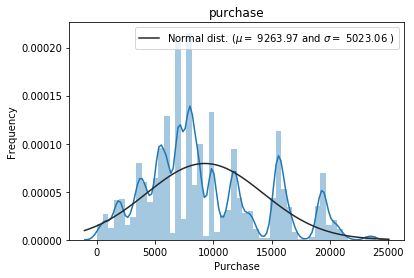

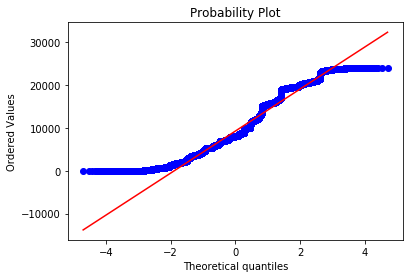

In [12]:


# Plotting Target vaiable


sns.distplot(purchase, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(purchase)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('purchase')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(purchase, plot=plt)
plt.show()



In [13]:
combine = pd.concat([train, test], sort=True, ignore_index=True)
combine.drop('Purchase', axis=1, inplace=True)

# Missing Values

In [14]:
# Dataframe that shows Null count and percent odf null counts of all features.
def checkNull(dataFrame):
    nullCount = dataFrame.isnull().sum().sort_values(ascending=False)
    nullCount = nullCount[nullCount != 0]
    nullPercent = ((nullCount)/combine.shape[0]) * 100
    nullCols = pd.DataFrame([nullCount, nullPercent], index=['Count', 'Percent']).transpose()
    return nullCols

In [15]:
nullCols = checkNull(combine)
nullCols.head(10)

,Count,Percent
Product_Category_3,545809.0,69.648078
Product_Category_2,245982.0,31.388587


In [16]:
combine.fillna(-999, inplace=True)

# Correlation

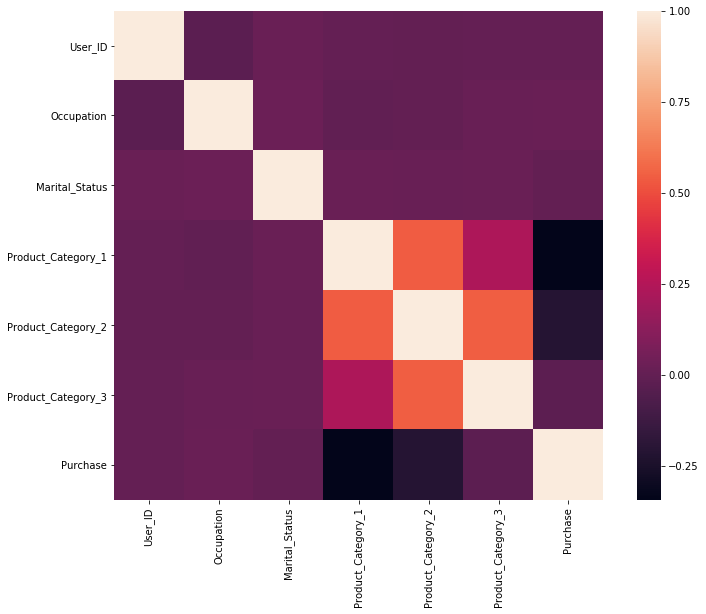

In [17]:
# Visualising Correlation

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, square=True)

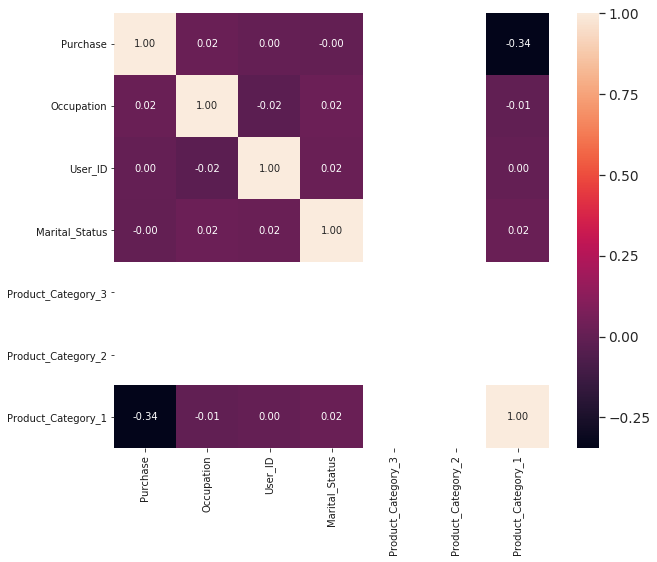

In [18]:
k = 12
selectedCols = corrmat.nlargest(k, 'Purchase')['Purchase'].index
cm = np.corrcoef(train[selectedCols].values.T)
f, ax = plt.subplots(figsize=(10, 8))

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size' : 10}, yticklabels=selectedCols.values, xticklabels=selectedCols.values)
plt.show()

# Feature Engeneering

In [19]:
meanPrice = train.groupby('Product_ID')['Purchase'].mean()
meanPrice = meanPrice.rename('MeanPurchase')

In [20]:
categoryPrice = train.groupby('Product_Category_1')['Purchase'].mean()
categoryPrice = categoryPrice.rename('CategoryPurchase')

In [21]:
categoryPrice

Product_Category_1
1     13606.218596
2     11251.935384
3     10096.705734
4      2329.659491
5      6240.088178
6     15838.478550
7     16365.689600
8      7498.958078
9     15537.375610
10    19675.570927
11     4685.268456
12     1350.859894
13      722.400613
14    13141.625739
15    14780.451828
16    14766.037037
17    10170.759516
18     2972.864320
19       37.041797
20      370.481176
Name: CategoryPurchase, dtype: float64

In [22]:
lowerAgeDix = {'0-17': 0, '18-25': 18, '26-35': 26, '36-45': 36, '46-50': 46, '51-55': 51, '55+': 55 }

In [23]:
upperAgeDix = {'0-17': 17, '18-25': 25, '26-35': 35, '36-45': 45, '46-50': 50, '51-55': 55, '55+': 75 }

In [24]:
combine['Lower_Age'] = combine['Age'].map(lowerAgeDix)

In [25]:
combine['Upper_Age'] = combine['Age'].map(upperAgeDix)

In [26]:
combine.Stay_In_Current_City_Years = combine.Stay_In_Current_City_Years.replace('4+', 4)

In [27]:
combine = combine.join(meanPrice, on='Product_ID')

In [28]:
combine = combine.join(categoryPrice, on='Product_Category_1')

In [29]:
combine

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Stay_In_Current_City_Years,User_ID,Lower_Age,Upper_Age,MeanPurchase,CategoryPurchase
0,0-17,A,F,0,10,3,-999.0,-999.0,P00069042,2,1000001,0,17,11870.863436,10096.705734
1,0-17,A,F,0,10,1,6.0,14.0,P00248942,2,1000001,0,17,16304.030981,13606.218596
2,0-17,A,F,0,10,12,-999.0,-999.0,P00087842,2,1000001,0,17,1237.892157,1350.859894
3,0-17,A,F,0,10,12,14.0,-999.0,P00085442,2,1000001,0,17,1455.140762,1350.859894
4,55+,C,M,0,16,8,-999.0,-999.0,P00285442,4,1000002,55,75,7692.763547,7498.958078
5,26-35,A,M,0,15,1,2.0,-999.0,P00193542,3,1000003,26,35,14318.772358,13606.218596
6,46-50,B,M,1,7,1,8.0,17.0,P00184942,2,1000004,46,50,16899.227083,13606.218596
7,46-50,B,M,1,7,1,15.0,-999.0,P00346142,2,1000004,46,50,14169.618887,13606.218596
8,46-50,B,M,1,7,1,16.0,-999.0,P0097242,2,1000004,46,50,15947.346491,13606.218596
9,26-35,A,M,1,20,8,-999.0,-999.0,P00274942,1,1000005,26,35,8068.920555,7498.958078


In [30]:
feat = 'MeanPurchase'
combine[feat + '-s2'] = combine[feat] ** 2
combine[feat + '-s3'] = combine[feat] ** 3
combine[feat + '-Sq'] = np.sqrt(combine[feat])

In [31]:
user_id_to_category_map = {}
customer_purchase_power = train.groupby("User_ID")["Purchase"].sum()
values = customer_purchase_power.iteritems()

for key, val in values:
    if val <= 146570.0:
        user_id_to_category_map[key] = 1
    elif val <= 205272.0:
        user_id_to_category_map[key] = 2
    elif val <= 279288.0:
        user_id_to_category_map[key] = 3
    elif val <= 383455.0:
        user_id_to_category_map[key] = 4
    elif val <= 521213.0:
        user_id_to_category_map[key] = 5
    elif val <= 698842.0:
        user_id_to_category_map[key] = 6
    elif val <= 942900.0:
        user_id_to_category_map[key] = 7
    elif val <= 1355245.0:
        user_id_to_category_map[key] = 8
    elif val <= 2069404.0:
        user_id_to_category_map[key] = 9
    else:
        user_id_to_category_map[key] = 10


def get_customer_category(user_id):
    if user_id in user_id_to_category_map:
        return user_id_to_category_map[user_id]
    return 5


# Tagged each user with a category id
combine["user_category"] = list(map(lambda user_id: get_customer_category(user_id), combine["User_ID"]))


In [32]:
combine

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Stay_In_Current_City_Years,User_ID,Lower_Age,Upper_Age,MeanPurchase,CategoryPurchase,MeanPurchase-s2,MeanPurchase-s3,MeanPurchase-Sq,user_category
0,0-17,A,F,0,10,3,-999.0,-999.0,P00069042,2,1000001,0,17,11870.863436,10096.705734,1.409174e+08,1.672811e+12,108.953492,4
1,0-17,A,F,0,10,1,6.0,14.0,P00248942,2,1000001,0,17,16304.030981,13606.218596,2.658214e+08,4.333961e+12,127.687239,4
2,0-17,A,F,0,10,12,-999.0,-999.0,P00087842,2,1000001,0,17,1237.892157,1350.859894,1.532377e+06,1.896917e+09,35.183692,4
3,0-17,A,F,0,10,12,14.0,-999.0,P00085442,2,1000001,0,17,1455.140762,1350.859894,2.117435e+06,3.081165e+09,38.146307,4
4,55+,C,M,0,16,8,-999.0,-999.0,P00285442,4,1000002,55,75,7692.763547,7498.958078,5.917861e+07,4.552471e+11,87.708401,7
5,26-35,A,M,0,15,1,2.0,-999.0,P00193542,3,1000003,26,35,14318.772358,13606.218596,2.050272e+08,2.935738e+12,119.661073,4
6,46-50,B,M,1,7,1,8.0,17.0,P00184942,2,1000004,46,50,16899.227083,13606.218596,2.855839e+08,4.826147e+12,129.997027,3
7,46-50,B,M,1,7,1,15.0,-999.0,P00346142,2,1000004,46,50,14169.618887,13606.218596,2.007781e+08,2.844949e+12,119.036208,3
8,46-50,B,M,1,7,1,16.0,-999.0,P0097242,2,1000004,46,50,15947.346491,13606.218596,2.543179e+08,4.055695e+12,126.282804,3
9,26-35,A,M,1,20,8,-999.0,-999.0,P00274942,1,1000005,26,35,8068.920555,7498.958078,6.510748e+07,5.253471e+11,89.827170,7


In [33]:
combine.Occupation.unique()

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6])

In [34]:
combine.dtypes

Age                            object
City_Category                  object
Gender                         object
Marital_Status                  int64
Occupation                      int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Product_ID                     object
Stay_In_Current_City_Years     object
User_ID                         int64
Lower_Age                       int64
Upper_Age                       int64
MeanPurchase                  float64
CategoryPurchase              float64
MeanPurchase-s2               float64
MeanPurchase-s3               float64
MeanPurchase-Sq               float64
user_category                   int64
dtype: object

In [35]:
combine = pd.get_dummies(combine, columns=['City_Category', 'Gender', 'Marital_Status', 'Stay_In_Current_City_Years'])

In [36]:
combine['Product_ID'] = combine['Product_ID'].str[1:]

In [37]:
combine.index.nunique()

783667

In [38]:
combine['Product_ID'] = combine['Product_ID'].astype('int64')
combine['Product_Category_2'] = combine['Product_Category_2'].astype('int64')
combine['Product_Category_3'] = combine['Product_Category_3'].astype('int64')

In [39]:
le = LabelEncoder()

In [40]:
combine['Age'] = le.fit_transform(combine.Age)

In [41]:
combine.dtypes

Age                               int64
Occupation                        int64
Product_Category_1                int64
Product_Category_2                int64
Product_Category_3                int64
Product_ID                        int64
User_ID                           int64
Lower_Age                         int64
Upper_Age                         int64
MeanPurchase                    float64
CategoryPurchase                float64
MeanPurchase-s2                 float64
MeanPurchase-s3                 float64
MeanPurchase-Sq                 float64
user_category                     int64
City_Category_A                   uint8
City_Category_B                   uint8
City_Category_C                   uint8
Gender_F                          uint8
Gender_M                          uint8
Marital_Status_0                  uint8
Marital_Status_1                  uint8
Stay_In_Current_City_Years_4      uint8
Stay_In_Current_City_Years_0      uint8
Stay_In_Current_City_Years_1      uint8


In [42]:
combine.Product_Category_2.unique()

array([-999,    6,   14,    2,    8,   15,   16,   11,    5,    3,    4,
         12,    9,   10,   17,   13,    7,   18])

In [43]:
train = combine[combine.index < 550068].copy()
test = combine[combine.index >= 550068].copy()

In [44]:
combine.index

RangeIndex(start=0, stop=783667, step=1)

In [45]:
train.shape

(550068, 27)

In [46]:
train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            550058, 550059, 550060, 550061, 550062, 550063, 550064, 550065,
            550066, 550067],
           dtype='int64', length=550068)

In [47]:
purchase.shape

(550068,)

In [48]:
test.shape

(233599, 27)

In [49]:
test.index = range(233599)

In [50]:
test.index

RangeIndex(start=0, stop=233599, step=1)

# Modelling

In [51]:
x_train, cv, y_train, y_cv = train_test_split(train, purchase, test_size=0.25, random_state=42)

In [52]:
x_train.index

Int64Index([212363,  41298, 470717, 394764, 265659, 111363,  98061, 146374,
            348055, 482833,
            ...
            175203,  87498, 521430, 137337,  54886, 110268, 259178, 365838,
            131932, 121958],
           dtype='int64', length=412551)

In [53]:
y_train.index

Int64Index([212363,  41298, 470717, 394764, 265659, 111363,  98061, 146374,
            348055, 482833,
            ...
            175203,  87498, 521430, 137337,  54886, 110268, 259178, 365838,
            131932, 121958],
           dtype='int64', length=412551)

In [55]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [57]:
def modelFit(alg, x_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    alg.fit(x_train, y_train, eval_metric='rmse')
    
    return alg
    
    
    

In [93]:
paramDix = {'max_depth' : 11,
'min_child_weight' : 6,
'gamma' : 0.0,
'subsample' : 0.95,
'colsample_bytree' : 0.95,
'reg_alpha' : 0.1,
'learning_rate': 0.1,
'n_estimators': 300
}

In [94]:
xgb1 = XGBRegressor(
 learning_rate =paramDix['learning_rate'],
 n_estimators=paramDix['n_estimators'],
 max_depth=paramDix['max_depth'],
 min_child_weight=paramDix['min_child_weight'],
 gamma=paramDix['gamma'],
 subsample=paramDix['subsample'],
 colsample_bytree=paramDix['colsample_bytree'],
 reg_alpha=paramDix['reg_alpha'],
 objective= 'reg:linear',
 scale_pos_weight=1,
 seed=27)
xgbMod1 = modelFit(xgb1, x_train, y_train)

In [95]:
print("RMSE score(CV): ", (rmse_cv(xgbMod1, cv, y_cv)).mean())
print("RMSE score(Train): ", (rmse_cv(xgbMod1, x_train, y_train)).mean())

RMSE score(CV):  2582.198711630147
RMSE score(Train):  2476.629789310523


In [96]:
xgbMod1.__dict__

{'max_depth': 11,
 'learning_rate': 0.1,
 'n_estimators': 300,
 'silent': True,
 'objective': 'reg:linear',
 'booster': 'gbtree',
 'gamma': 0.0,
 'min_child_weight': 6,
 'max_delta_step': 0,
 'subsample': 0.95,
 'colsample_bytree': 0.95,
 'colsample_bylevel': 1,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'missing': nan,
 'kwargs': {},
 '_Booster': <xgboost.core.Booster at 0x7f86be781ac8>,
 'seed': 27,
 'random_state': 0,
 'nthread': None,
 'n_jobs': 1}

In [97]:
y_predict = xgbMod1.predict(test)

In [98]:
submission = pd.DataFrame({
    'User_ID': test.User_ID,
    'Product_ID': pr_Id,
    'Purchase': y_predict
})

In [99]:
submission.to_csv('submissionXGBTuned_7_09_4.csv', index=False)